## RUONIA SDE — Baseline (Vasicek), SINDy-like (Optuna), e-SINDy, Bayesian SINDy

In [3]:
import os, math, itertools, functools, warnings, traceback, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from numpy.linalg import lstsq, LinAlgError
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, ARDRegression
plt.rcParams['figure.dpi'] = 130

os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, linewidth=200)

## 0. Загрузка данных и подготовка
- RUONIA как целевая переменная.
- Экзогенные факторы (IRS, OFZ, FX, IMOEX).
- Train/Test сплит по времени выполняется **до** масштабирования.
- Z-скейлинг: `sc_x`, `sc_u` фиттятся **только на train**, затем применяются ко всему.
- Обучение дрейфа — на годовой скорости в z-масштабе: `drift_z = Δr_z / dt` (годы).
- Временная сетка: средний шаг в годах (`dt_years`), а для дискретного цикла используем `dt = 1/365`.

In [4]:
keep = ['ruonia_ruonia','roisfix_1W','roisfix_2W','roisfix_1M','roisfix_2M',
        'roisfix_3M','roisfix_6M','roisfix_1Y',
        'usd_usd_rub','eur_eur_rub','cny_cny_rub','imoex_moex_close',
        'zcyc_0.25','zcyc_0.5','zcyc_0.75','zcyc_1.0','zcyc_2.0','zcyc_3.0',
        'zcyc_5.0','zcyc_7.0','zcyc_10.0','zcyc_15.0','zcyc_20.0','zcyc_30.0']

DATA_PATH = "/Users/dmlast/Documents/Projects/ruonia-forecast/data/raw/merged_20140116_20250707.parquet"

df = (pd.read_parquet(Path(DATA_PATH))[['KEY_DATE', *keep]]
      .ffill().dropna())
df['KEY_DATE'] = pd.to_datetime(df['KEY_DATE'])
df.set_index('KEY_DATE', inplace=True)

# Базовые массивы
r_full = df['ruonia_ruonia'].astype(float).to_numpy()             # уровень r_t
U_full = df.drop(columns='ruonia_ruonia').astype(float).to_numpy() # экзогены u_t
dates  = df.index.values
N      = len(r_full)

d_days   = np.diff(dates) / np.timedelta64(1, 'D')
dt_years = float(np.mean(d_days)) / 365.0       # средний календарный шаг в годах (для Васичека)
dt       = 1/365.0                               # используем как дискретный шаг для итераций

TEST_DAYS = 91  
cut_idx   = min(max(1, N - TEST_DAYS), N - 1)
idx_train = np.arange(0, cut_idx)        # индексы t для train переходов
idx_test  = np.arange(cut_idx, N - 1)    # индексы t для test переходов

# Масштабирование: фит только на train уровнях r_t и u_t
sc_x = StandardScaler().fit(r_full[idx_train].reshape(-1, 1))
sc_u = StandardScaler().fit(U_full[idx_train])

r_z_full = sc_x.transform(r_full.reshape(-1, 1)).ravel()
U_z_full = sc_u.transform(U_full)

# Для одношаговых переходов (выровнено по t)
x_z_full = r_z_full[:-1]             # r_z(t)
dr_z     = np.diff(r_z_full)         # r_z(t+1) - r_z(t)
drift_z  = dr_z / dt                 # ГОДОВАЯ скорость в z-масштабе (целевой для дрейфа)

# Для обратного масштаба (ориг.)
mu_r, sd_r = float(sc_x.mean_[0]), float(sc_x.scale_[0])
mu_u_map = dict(zip(df.drop(columns='ruonia_ruonia').columns, sc_u.mean_))
sd_u_map = dict(zip(df.drop(columns='ruonia_ruonia').columns, sc_u.scale_))

## 1. Бейслайн: Vasicek / OU (оценка на train)
Оцениваем дискретную форму $r_{t+1} = A + B r_t + eps$ на train, затем восстанавливаем параметры $(\kappa, \theta, \sigma)$ и строим мульти-горизонтные прогнозы.

In [31]:
y_tr = r_full[idx_train + 1]
x_tr = r_full[idx_train]
X_tr = np.column_stack([np.ones_like(x_tr), x_tr])
beta_tr, *_ = np.linalg.lstsq(X_tr, y_tr, rcond=None)
A_hat, B_hat = map(float, beta_tr)

eps_tr  = y_tr - (A_hat + B_hat * x_tr)
s2_hat  = float(np.mean(eps_tr**2))  # дисперсия одношаговой ошибки на train

if not (0 < B_hat < 1):
    print(f"[Предупреждение] Vasicek (train) B={B_hat:.4f} вне (0,1) → возможны нестабильности OU.")

kappa_hat = -math.log(max(B_hat, 1e-12)) / max(dt_years, 1e-12)
theta_hat = A_hat / (1.0 - B_hat) if abs(1.0 - B_hat) > 1e-12 else np.nan
sigma2_hat = 2.0 * kappa_hat * s2_hat / max(1.0 - B_hat**2, 1e-12)
sigma_hat  = float(np.sqrt(max(sigma2_hat, 0.0)))

print("=== Vasicek (fit on train) ===")
print(f"A={A_hat:.6f}, B={B_hat:.6f} | kappa={kappa_hat:.6f}, theta={theta_hat:.6f}, sigma={sigma_hat:.6f}")
print(f"step-σ (train OLS) = {np.sqrt(s2_hat):.6f}  |  dt_years ≈ {dt_years:.6f}")

def vasicek_forecast_path(r0, kappa, theta, sigma, h_days):
    h_years = h_days / 365.0
    mean_h  = theta + (r0 - theta) * math.exp(-kappa * h_years)
    var_h   = (sigma**2) * (1.0 - math.exp(-2*kappa*h_years)) / (2*kappa + 1e-18)
    std_h   = math.sqrt(max(var_h, 1e-18))
    return mean_h, std_h

H_LIST = [7, 14, 30]

def vasicek_multi_h_forecasts(r_series, start_idx_range, H_list, kappa, theta, sigma):
    out = {H: dict(mean=[], std=[], t_index=[]) for H in H_list}
    for t in start_idx_range:
        r0 = r_series[t]
        for H in H_list:
            m, s = vasicek_forecast_path(r0, kappa, theta, sigma, H)
            out[H]["mean"].append(m)
            out[H]["std"].append(s)
            out[H]["t_index"].append(t)
    for H in H_list:
        for k in ["mean","std","t_index"]:
            out[H][k] = np.asarray(out[H][k])
    return out

vas_forecasts_train = vasicek_multi_h_forecasts(r_full, idx_train, H_LIST, kappa_hat, theta_hat, sigma_hat)
vas_forecasts_test  = vasicek_multi_h_forecasts(r_full, idx_test,  H_LIST, kappa_hat, theta_hat, sigma_hat)

=== Vasicek (fit on train) ===
A=0.020605, B=0.998270 | kappa=0.632016, theta=11.910155, sigma=5.866331
step-σ (train OLS) = 0.306792  |  dt_years ≈ 0.002740


## 2. SINDy-like 

In [6]:
swap_pool = ['roisfix_1W','roisfix_2W','roisfix_1M','roisfix_2M','roisfix_3M','roisfix_6M','roisfix_1Y']
ofz_pool  = ['zcyc_'+s for s in ['0.25','0.5','0.75','1.0','2.0','3.0','5.0','7.0','10.0','15.0','20.0','30.0']]
fx_full   = ['usd_usd_rub','eur_eur_rub','cny_cny_rub']

def all_subsets(lst):
    out = [[]]
    for x in lst:
        out += [s+[x] for s in out]
    return out

fx_subsets = [tuple(s) for s in all_subsets(fx_full)]  

def safe_inv_z(x):
    eps = 1e-8
    return 1.0 / np.where(np.abs(x) > eps, x, np.sign(x + 1e-12) * eps)

def build_theta_z(rz: np.ndarray,
                  uz: np.ndarray,
                  u_names: list,
                  deg_r: int = 4,
                  add_special: bool = True,
                  add_trig: bool = True,
                  deg_u: int = 2,
                  add_ru_cross: bool = True,
                  add_uu_cross: bool = True):
    n = rz.shape[0]
    cols = []; names = []
    cols.append(np.ones(n)); names.append('1')
    cols.append(rz);        names.append('r_z')
    if deg_r >= 2: cols.append(rz**2); names.append('r_z^2')
    if deg_r >= 3: cols.append(rz**3); names.append('r_z^3')
    if deg_r >= 4: cols.append(rz**4); names.append('r_z^4')
    if deg_r >= 5: cols.append(rz**5); names.append('r_z^5')
    if add_special:
        cols.append(np.sqrt(np.maximum(rz, 1e-12))); names.append('sqrt(r_z)')
        cols.append(safe_inv_z(rz));                 names.append('1/r_z')
    if add_trig:
        cols.append(np.sin(rz)); names.append('sin(r_z)')
        cols.append(np.cos(rz)); names.append('cos(r_z)')
    for j, nm in enumerate(u_names):
        cols.append(uz[:, j]); names.append(nm)
    if deg_u >= 2:
        for j, nm in enumerate(u_names):
            cols.append(uz[:, j]**2); names.append(f'{nm}^2')
    if add_ru_cross:
        for j, nm in enumerate(u_names):
            cols.append(rz * uz[:, j]); names.append(f'r_z*{nm}')
    if add_uu_cross and len(u_names) >= 2:
        for i in range(len(u_names)):
            for j in range(i+1, len(u_names)):
                cols.append(uz[:, i] * uz[:, j]); names.append(f'{u_names[i]}*{u_names[j]}')
    Theta = np.column_stack(cols)
    return Theta, names

def aicc(n, rss, k):
    rss = max(float(rss), 1e-18)
    aic = n * math.log(rss / n) + 2 * k
    if n - k - 1 > 0:
        aic += (2 * k * (k + 1)) / (n - k - 1)
    return aic

def fit_lasso_with_pruning(Theta, y, alpha_center, nnz_min=7, nnz_max=10):
    n, q = Theta.shape
    scale = np.ones(q, float)
    for j in range(1, q):
        s = float(np.std(Theta[:, j]))
        scale[j] = s if s > 1e-12 else 1.0
    Xn = Theta / scale
    loga = math.log10(alpha_center)
    grid = np.clip(np.linspace(loga - 0.7, loga + 0.7, 7), -7, -0.5)
    ALPHAS = 10.0**grid

    best = dict(aic=np.inf)
    best_intermediate = np.inf
    for a in ALPHAS:
        l = Lasso(alpha=a, fit_intercept=False, max_iter=4000)
        l.fit(Xn, y)
        beta = l.coef_ / scale
        nz = np.flatnonzero(np.abs(beta) > 1e-10)
        if nz.size < nnz_min:
            continue
        order = np.argsort(-np.abs(beta))
        Kmax = min(max(nz.size, nnz_min), nnz_max)
        for K in range(nnz_min, Kmax + 1):
            sel = order[:K]
            Xs = Theta[:, sel]
            try:
                b_ls, *_ = lstsq(Xs, y, rcond=None)
            except LinAlgError:
                continue
            yhat = Xs @ b_ls
            rss  = float(np.sum((y - yhat)**2))
            aic  = aicc(n, rss, K)
            if aic < best_intermediate:
                best_intermediate = aic
            if aic < best['aic']:
                beta_full = np.zeros(q)
                beta_full[sel] = b_ls
                best = dict(aic=aic, k=K, alpha=a, coef_raw=beta_full, mask=tuple(sel))
    return best, best_intermediate

def top_k_by_corr(group_cols, k):
    idxs = [df.drop(columns='ruonia_ruonia').columns.get_loc(c) for c in group_cols]
    mat  = U_z_full[idx_train][:, idxs]
    corr = np.array([np.corrcoef((np.diff(r_z_full)/ (1/365.0))[idx_train], mat[:, j])[0, 1] for j in range(mat.shape[1])])
    corr = np.nan_to_num(corr, nan=0.0)
    order = np.argsort(np.abs(corr))[::-1][:k]
    return [group_cols[i] for i in order]

TOP_SWAP = 4
TOP_OFZ  = 6
swap_top = top_k_by_corr(swap_pool, TOP_SWAP)
ofz_top  = top_k_by_corr(ofz_pool , TOP_OFZ)

def combos(pool, k_max=3):
    return [c for k in range(1, k_max+1) for c in itertools.combinations(pool, k)]

swap_choices = combos(swap_top, 3)  
ofz_choices  = combos(ofz_top , 3)

dt_vec_years = (np.diff(dates) / np.timedelta64(1, 'D')).astype(float) / 365.0
dt_default   = float(np.median(dt_vec_years)) if len(dt_vec_years)>0 else (1/365.0)

def estimate_uz_ar1_coeffs(Uz: np.ndarray, idx_tr: np.ndarray) -> np.ndarray:
    K = Uz.shape[1]
    rho = np.zeros(K, float)
    tL = idx_tr
    tR = idx_tr + 1
    for j in range(K):
        x = Uz[tL, j]
        y = Uz[tR, j]
        num = float(np.dot(x, y))
        den = float(np.dot(x, x)) + 1e-12
        r  = num / den
        rho[j] = float(np.clip(r, -0.99, 0.99))
    return rho

NNZ_DRIFT_MIN, NNZ_DRIFT_MAX = 7, 10
NNZ_SIGMA_MIN, NNZ_SIGMA_MAX = 3, 10

VAL_STEPS = min(90, max(10, len(idx_train)//5))
val_start = idx_train[-VAL_STEPS] if VAL_STEPS < len(idx_train) else idx_train[0]
idx_tr_in = np.arange(idx_train[0], val_start, dtype=int)
idx_vl_in = np.arange(val_start,      idx_train[-1]+1, dtype=int)

y_tr_in = (np.diff(r_z_full)[idx_tr_in]) / np.clip(dt_vec_years[idx_tr_in], 1e-10, None)
x_tr_in = r_z_full[idx_tr_in]
x_vl_in = r_z_full[idx_vl_in]
r_true_vl_right = r_full[idx_vl_in + 1]
dt_vl = np.clip(dt_vec_years[idx_vl_in], 1e-10, None)

def sample_config():
    sel_swap = random.choice(swap_choices)
    sel_ofz  = random.choice(ofz_choices)
    sel_fx   = random.choice([tuple([])]+[(fx,) for fx in fx_full]+list(itertools.combinations(fx_full,2))+[tuple(fx_full)])
    return dict(
        cols   = list(sel_swap) + list(sel_ofz) + ['imoex_moex_close'] + list(sel_fx),
        deg_r  = random.choice([3,4,5]),
        deg_u  = random.choice([1,2]),
        trig   = random.choice([False, True]),
        spec   = True,
        ru_x   = random.choice([False, True]),
        uu_x   = random.choice([False, True]),
        alpha0 = 10.0**np.random.uniform(-6,-2),
    )

best_pack = None
best_score = np.inf

for trial in range(160):  
    cfg = sample_config()
    exog_idx = [df.drop(columns='ruonia_ruonia').columns.get_loc(c) for c in cfg['cols']]

    Theta_tr_in, names = build_theta_z(
        x_tr_in,
        U_z_full[idx_tr_in][:, exog_idx],
        cfg['cols'],
        deg_r=cfg['deg_r'], add_special=cfg['spec'], add_trig=cfg['trig'],
        deg_u=cfg['deg_u'], add_ru_cross=cfg['ru_x'], add_uu_cross=cfg['uu_x']
    )
    best_drift, _ = fit_lasso_with_pruning(Theta_tr_in, y_tr_in, cfg['alpha0'],
                                           nnz_min=NNZ_DRIFT_MIN, nnz_max=NNZ_DRIFT_MAX)
    if not np.isfinite(best_drift['aic']):
        continue
    coef_raw = best_drift['coef_raw']
    sel = np.flatnonzero(np.abs(coef_raw) > 1e-12)
    if sel.size == 0:
        continue

    Xs = Theta_tr_in[:, sel]
    lam = 1e-6
    b_ls = np.linalg.solve(Xs.T @ Xs + lam*np.eye(sel.size), Xs.T @ y_tr_in)
    coef = np.zeros_like(coef_raw); coef[sel] = b_ls

    def build_theta_vec(rz_vec, uz_mat, cfg):
        n = rz_vec.shape[0]
        cols_list = [np.ones(n), rz_vec]
        if cfg['deg_r']>=2: cols_list.append(rz_vec**2)
        if cfg['deg_r']>=3: cols_list.append(rz_vec**3)
        if cfg['deg_r']>=4: cols_list.append(rz_vec**4)
        if cfg['deg_r']>=5: cols_list.append(rz_vec**5)
        if cfg['spec']:
            cols_list.append(np.sqrt(np.maximum(rz_vec,1e-12)))
            cols_list.append(1.0/np.where(np.abs(rz_vec)>1e-8, rz_vec, np.sign(rz_vec+1e-12)*1e-8))
        if cfg['trig']:
            cols_list.append(np.sin(rz_vec)); cols_list.append(np.cos(rz_vec))
        cols_list.append(uz_mat)
        if cfg['deg_u']>=2: cols_list.append(uz_mat**2)
        if cfg['ru_x']:     cols_list.append(rz_vec[:,None]*uz_mat)
        if cfg['uu_x'] and uz_mat.shape[1]>=2:
            cols_list.append(np.column_stack([uz_mat[:,i]*uz_mat[:,j] for i in range(uz_mat.shape[1]) for j in range(i+1,uz_mat.shape[1])]))
        return np.column_stack(cols_list)

    Uz_vl_left = U_z_full[idx_vl_in][:, exog_idx]
    Theta_vl   = build_theta_vec(x_vl_in, Uz_vl_left, cfg)
    a_pred     = Theta_vl @ coef                     
    r_left     = r_full[idx_vl_in]
    r_hat      = r_left + sd_r * a_pred * dt_vl     

    rmse = float(np.sqrt(np.mean((r_true_vl_right - r_hat)**2)))
    if rmse < best_score:
        best_score = rmse
        best_pack  = (cfg, names, exog_idx, coef)

print(f"[SINDy-like CV] Best one-step RMSE(val) = {best_score:.6f}")

cfg, names_z, exog_idx, coef_z = best_pack

Theta_train, names_best = build_theta_z(
    r_z_full[idx_train],
    U_z_full[idx_train][:, exog_idx],
    cfg['cols'],
    deg_r=cfg['deg_r'], add_special=cfg['spec'], add_trig=cfg['trig'],
    deg_u=cfg['deg_u'], add_ru_cross=cfg['ru_x'], add_uu_cross=cfg['uu_x']
)

a_tr = Theta_train @ coef_z
res_drift_train = np.diff(r_z_full)[idx_train] - a_tr * np.clip(dt_vec_years[idx_train], 1e-10, None)
y_sigma_train   = np.log((res_drift_train**2) / np.clip(dt_vec_years[idx_train], 1e-10, None) + 1e-12)

best_s, _ = fit_lasso_with_pruning(Theta_train, y_sigma_train, 1e-3,
                                   nnz_min=NNZ_SIGMA_MIN, nnz_max=NNZ_SIGMA_MAX)
gamma = best_s['coef_raw']
print(f"[SINDy-like] Диффузия подобрана: термов ~{np.count_nonzero(np.abs(gamma)>1e-12)}")

[SINDy-like CV] Best one-step RMSE(val) = 0.167220
[SINDy-like] Диффузия подобрана: термов ~10


### 2.1 Формулы в оригинальном масштабе (dr/dt и σ(r,u))
Корректный маппинг с учётом того, что дрейф обучен как **скорость** в z-масштабе.

In [7]:
def add_term(d, k, v):
    d[k] = d.get(k, 0.0) + float(v)

def expand_rz_power(k, coef, mu, sig, out, mult=1.0):
    """
    Разложение ((r - mu)/sig)^k в полином по r.
    mult — общий множитель (для дрейфа mult=sd_r, для диффузии mult=1).
    """
    from math import comb
    sigk = sig ** k if k > 0 else 1.0
    for i in range(0, k+1):
        # ((r - mu)^k)/sig^k = sum_{i=0}^k C(k,i) r^i * (-mu)^(k-i) / sig^k
        c = mult * coef * comb(k, i) * ((-mu) ** (k - i)) / sigk
        add_term(out, '1' if i == 0 else ('r' if i == 1 else f'r^{i}'), c)

def expand_uz_power(var, k, coef, mu, sig, out, mult=1.0):
    """
    Разложение по экзогенам: ((u - mu)/sig)^k.
    """
    if k == 1:
        add_term(out, var, mult * coef / sig)
        add_term(out, '1',  mult * coef * (-mu / sig))
    elif k == 2:
        sig2 = sig * sig
        add_term(out, f'{var}^2', mult * coef / sig2)
        add_term(out, var,        mult * coef * (-2*mu / sig2))
        add_term(out, '1',        mult * coef * (mu*mu / sig2))

def expand_rz_uz_cross(var, coef, mu_r_, sd_r_, mu_u_, sd_u_, out, mult=1.0):
    """
    r_z * u_z = ((r - mu_r)/sd_r) * ((u - mu_u)/sd_u)
    """
    c0 = mult * coef / (sd_r_ * sd_u_)
    add_term(out, f'r*{var}', c0)
    add_term(out, 'r',        - c0 * mu_u_)
    add_term(out, var,        - c0 * mu_r_)
    add_term(out, '1',         c0 * mu_r_ * mu_u_)

def expand_uz_uz_cross(var_i, var_j, coef, mu_u, sd_u, out, mult=1.0):
    """
    u_i_z * u_j_z  для i<j.
    """
    si, sj = sd_u[var_i], sd_u[var_j]
    mi, mj = mu_u[var_i], mu_u[var_j]
    c0 = mult * coef / (si * sj)
    add_term(out, f'{var_i}*{var_j}', c0)
    add_term(out, var_i, -c0 * mj)
    add_term(out, var_j, -c0 * mi)
    add_term(out, '1',    c0 * mi * mj)

def map_coef_to_original(names, beta_raw, u_names):
    """
    Маппинг дрейфа: μ(r,u) = dr/dt = sd_r * Σ c_j * φ_j(r_z, u_z).
    """
    out = {}
    for nm, c in zip(names, beta_raw):
        if abs(c) < 1e-12:
            continue
        mult = sd_r  
        if nm == '1':
            add_term(out, '1', mult * c)
        elif nm == 'r_z':
            # (r - mu_r)/sd_r
            add_term(out, 'r', mult * c / sd_r)
            add_term(out, '1', mult * c * (-mu_r / sd_r))
        elif nm.startswith('r_z^'):
            k = int(nm.split('^')[1])
            expand_rz_power(k, c, mu_r, sd_r, out, mult=sd_r)
        elif nm == 'sqrt(r_z)':
            # sqrt((r - mu_r)/sd_r) ~ (1/sqrt(sd_r)) * sqrt_shift
            add_term(out, 'sqrt_shift', mult * c / (sd_r**0.5))
        elif nm == '1/r_z':
            # 1/r_z = sd_r/(r - mu_r) -> коэффициент при 1/(r-mu_r)
            add_term(out, 'inv_shift', mult * c * sd_r)
        elif nm == 'sin(r_z)':
            add_term(out, 'sin_affine_r', mult * c)
        elif nm == 'cos(r_z)':
            add_term(out, 'cos_affine_r', mult * c)
        elif nm in u_names:
            expand_uz_power(nm, 1, c, mu_u_map[nm], sd_u_map[nm], out, mult=sd_r)
        elif nm.endswith('^2') and nm[:-2] in u_names:
            v = nm[:-2]
            expand_uz_power(v, 2, c, mu_u_map[v], sd_u_map[v], out, mult=sd_r)
        elif nm.startswith('r_z*'):
            v = nm.split('*', 1)[1]
            expand_rz_uz_cross(v, c, mu_r, sd_r, mu_u_map[v], sd_u_map[v], out, mult=sd_r*sd_r)  
        elif '*' in nm:
            vi, vj = nm.split('*')
            expand_uz_uz_cross(vi, vj, c, mu_u_map, sd_u_map, out, mult=sd_r)
    return out

# Пояснение к mult в cross r_z*u_z:
# μ = sd_r * [ c * ((r - mu_r)/sd_r)*((u - mu_u)/sd_u) ] = c * ((r - mu_r)*(u - mu_u))/sd_u
# Чтобы представить в виде комбинации базисов [r*u, r, u, 1], удобно дать expand_rz_uz_cross mult=sd_r,
# но внутри она делит ещё на sd_r*sd_u. Поэтому mult=sd_r*sd_r даёт итог c/sd_u (см. формулу выше).

def map_gamma_to_original(names, gamma, u_names):
    """
    Маппинг диффузии в экспоненте: g(r,u) = Σ γ_j * φ_j(r_z, u_z),
    σ(r,u) = sd_r * exp(0.5 * g(r,u)).
    """
    out = {}
    for nm, g in zip(names, gamma):
        if abs(g) < 1e-12:
            continue
        if nm == '1':
            add_term(out, '1', g)
        elif nm == 'r_z':
            add_term(out, 'r', g / sd_r)
            add_term(out, '1', g * (-mu_r / sd_r))
        elif nm.startswith('r_z^'):
            k = int(nm.split('^')[1])
            expand_rz_power(k, g, mu_r, sd_r, out, mult=1.0)
        elif nm == 'sqrt(r_z)':
            add_term(out, 'sqrt_shift', g / (sd_r**0.5))
        elif nm == '1/r_z':
            add_term(out, 'inv_shift',  g * sd_r)
        elif nm == 'sin(r_z)':
            add_term(out, 'sin_affine_r', g)
        elif nm == 'cos(r_z)':
            add_term(out, 'cos_affine_r', g)
        elif nm in u_names:
            expand_uz_power(nm, 1, g, mu_u_map[nm], sd_u_map[nm], out, mult=1.0)
        elif nm.endswith('^2') and nm[:-2] in u_names:
            v = nm[:-2]
            expand_uz_power(v, 2, g, mu_u_map[v], sd_u_map[v], out, mult=1.0)
        elif nm.startswith('r_z*'):
            v = nm.split('*', 1)[1]
            expand_rz_uz_cross(v, g, mu_r, sd_r, mu_u_map[v], sd_u_map[v], out, mult=1.0)
        elif '*' in nm:
            vi, vj = nm.split('*')
            expand_uz_uz_cross(vi, vj, g, mu_u_map, sd_u_map, out, mult=1.0)
    return out

def format_equation_drift(coefs, cols, mu_r, precision=6, eps=1e-10):
    order_poly = ['1','r','r^2','r^3','r^4','r^5']
    order_spec = ['sqrt_shift','inv_shift','sin_affine_r','cos_affine_r']
    order_u    = cols + [f'{c}^2' for c in cols]
    order_ru   = [f'r*{c}' for c in cols]
    order_uu   = [f'{cols[i]}*{cols[j]}' for i in range(len(cols)) for j in range(i+1,len(cols))]
    parts = []
    names_map = {
        'sqrt_shift': f"sqrt(r - {mu_r:.6g})",
        'inv_shift' : f"1/(r - {mu_r:.6g})",
        'sin_affine_r': f"sin({1.0/float(sd_r):.6g} * r + {-mu_r/float(sd_r):.6g})",
        'cos_affine_r': f"cos({1.0/float(sd_r):.6g} * r + {-mu_r/float(sd_r):.6g})",
    }
    def add_key(k):
        if k in coefs and abs(coefs[k]) > eps:
            label = names_map.get(k, k)
            parts.append(f"{coefs[k]:.{precision}g}" if k=='1' else f"{coefs[k]:.{precision}g} * {label}")
    for k in order_poly: add_key(k)
    for k in order_spec: add_key(k)
    for k in order_u:    add_key(k)
    for k in order_ru:   add_key(k)
    for k in order_uu:   add_key(k)
    rhs = " + ".join(parts) if parts else "0"
    return f"dr/dt = {rhs}"

def format_equation_sigma(coefs, cols, mu_r, precision=6, eps=1e-10):
    order_poly = ['1','r','r^2','r^3','r^4','r^5']
    order_spec = ['sqrt_shift','inv_shift','sin_affine_r','cos_affine_r']
    order_u    = cols + [f'{c}^2' for c in cols]
    order_ru   = [f'r*{c}' for c in cols]
    order_uu   = [f'{cols[i]}*{cols[j]}' for i in range(len(cols)) for j in range(i+1,len(cols))]
    parts = []
    names_map = {
        'sqrt_shift': f"sqrt(r - {mu_r:.6g})",
        'inv_shift' : f"1/(r - {mu_r:.6g})",
        'sin_affine_r': f"sin({1.0/float(sd_r):.6g} * r + {-mu_r/float(sd_r):.6g})",
        'cos_affine_r': f"cos({1.0/float(sd_r):.6g} * r + {-mu_r/float(sd_r):.6g})",
    }
    def add_key(k):
        if k in coefs and abs(coefs[k]) > eps:
            label = names_map.get(k, k)
            parts.append(f"{coefs[k]:.{precision}g}" if k=='1' else f"{coefs[k]:.{precision}g} * {label}")
    for k in order_poly: add_key(k)
    for k in order_spec: add_key(k)
    for k in order_u:    add_key(k)
    for k in order_ru:   add_key(k)
    for k in order_uu:   add_key(k)
    inner = " + ".join(parts) if parts else "0"
    return f"σ(r,u) = {sd_r:.6g} * exp(0.5 * ({inner}))"

cols = list(cfg['cols'])  

coefs_drift_orig = map_coef_to_original(names_best, coef_z, cols)
coefs_sigma_orig = map_gamma_to_original(names_best, gamma,  cols)

print("\n[SINDy-like] Дрейф (ориг. масштаб):")
print(format_equation_drift(coefs_drift_orig, cols, mu_r, precision=6))

print("\n[SINDy-like] Диффузия (ориг. масштаб):")
print(format_equation_sigma(coefs_sigma_orig, cols, mu_r, precision=6))



[SINDy-like] Дрейф (ориг. масштаб):
dr/dt = -78.8205 + 21.6254 * roisfix_1Y + -33.5243 * zcyc_5.0 + -188.817 * zcyc_10.0 + 206.848 * zcyc_15.0 + 0.00972053 * imoex_moex_close + -9.53179 * roisfix_1Y*zcyc_5.0 + 29.7468 * roisfix_1Y*zcyc_10.0 + -22.4689 * roisfix_1Y*zcyc_15.0 + 10.7208 * zcyc_5.0*zcyc_15.0 + 0.00310181 * zcyc_5.0*imoex_moex_close + -8.25841 * zcyc_10.0*zcyc_15.0 + -0.00409714 * zcyc_10.0*imoex_moex_close

[SINDy-like] Диффузия (ориг. масштаб):
σ(r,u) = 4.26363 * exp(0.5 * (-3.13038 + -0.0535557 * r + -0.374427 * roisfix_1Y + 0.168789 * zcyc_5.0 + 0.319765 * zcyc_15.0 + -0.00205816 * imoex_moex_close + 0.319712 * usd_usd_rub + -0.254313 * eur_eur_rub + -0.0248412 * roisfix_1Y*zcyc_15.0 + 0.00793424 * roisfix_1Y*eur_eur_rub + -9.58002e-05 * imoex_moex_close*usd_usd_rub + 0.000107268 * imoex_moex_close*eur_eur_rub + -0.00108046 * usd_usd_rub*eur_eur_rub))


### 2.2 Мульти-горизонтные прогнозы и 3σ-интервалы (SINDy-like)
Итеративно: каждый шаг добавляем средний дрейф (скорость * dt) и аккумулируем дисперсию как сумму `σ^2(r,u)*dt`.

In [8]:
def theta_row_single_fast(rz: float, uvec: np.ndarray,
                          deg_r: int, add_special: bool, add_trig: bool,
                          deg_u: int, add_ru_cross: bool, add_uu_cross: bool) -> np.ndarray:
    row = [1.0, rz]
    if deg_r >= 2: row.append(rz**2)
    if deg_r >= 3: row.append(rz**3)
    if deg_r >= 4: row.append(rz**4)
    if deg_r >= 5: row.append(rz**5)
    if add_special:
        row.append(np.sqrt(max(rz,1e-12)))
        row.append(1.0/(rz if abs(rz)>1e-8 else np.sign(rz+1e-12)*1e-8))
    if add_trig:
        row.append(np.sin(rz)); row.append(np.cos(rz))
    # экзогены
    row.extend(list(uvec))
    if deg_u >= 2:
        row.extend(list(uvec**2))
    if add_ru_cross:
        row.extend(list(rz * uvec))
    if add_uu_cross and len(uvec) >= 2:
        for i in range(len(uvec)):
            for j in range(i+1, len(uvec)):
                row.append(uvec[i]*uvec[j])
    return np.array(row, float)

def ar1_forecast_path(u0: np.ndarray, rho: np.ndarray, H: int) -> np.ndarray:
    K = u0.shape[0]
    path = np.empty((H, K), float)
    cur  = u0.astype(float).copy()
    for h in range(H):
        cur = rho * cur
        path[h, :] = cur
    return path

def safe_var_increment_from_g(g_val: float, sd: float, dt_y: float) -> float:
    """
    var_step = σ_year^2 * dt = (sd^2) * exp(g) * dt  с отсечками по g.
    """
    sd2 = float(sd) * float(sd)
    if not np.isfinite(g_val):
        return sd2 * dt_y * 1e-12
    LOG_MAX = math.log(np.finfo(float).max)
    SAFETY  = 1e2
    max_g = LOG_MAX - math.log(sd2) - math.log(SAFETY)
    min_g = -100.0
    g_clip = min(max(float(g_val), min_g), max_g)
    return sd2 * math.exp(g_clip) * dt_y

rho_Uz = estimate_uz_ar1_coeffs(U_z_full[:, exog_idx], idx_train)

def sindy_multi_h_forecasts(r_series, r_z_series, U_z_series, start_idx_range,
                            H_list, coef_z, gamma, cols, deg_r, deg_u, trig, spec, ru_x, uu_x):
    out = {H: dict(mean=[], std=[], t_index=[]) for H in H_list}
    maxH = max(H_list)
    for t in start_idx_range:
        r0  = r_series[t]
        rz0 = r_z_series[t]
        u0  = U_z_series[t, :]

        U_path = ar1_forecast_path(u0, rho_Uz, maxH)

        rz_curr = rz0
        r_curr  = r0
        var_sum = 0.0
        for step in range(1, maxH+1):
            u_vec = U_path[step-1, :]
            theta_row = theta_row_single_fast(rz_curr, u_vec,
                                              deg_r, spec, trig, deg_u, ru_x, uu_x)
            a_z_t  = float(theta_row @ coef_z)     # скорость год^-1

            dt_y = float(dt_vec_years[t + step - 1]) if (t + step - 1) < len(dt_vec_years) else dt_default
            r_curr  = r_curr + sd_r * a_z_t * dt_y

            if gamma is not None:
                g_val = float(theta_row @ gamma)
                var_sum += safe_var_increment_from_g(g_val, sd_r, dt_y)
            else:
                var_sum += (np.var(res_drift_train) * sd_r**2) * dt_y

            rz_curr = (r_curr - mu_r) / sd_r

            if step in H_list:
                out[step]["mean"].append(r_curr)
                out[step]["std"].append(math.sqrt(max(var_sum, 1e-18)))
                out[step]["t_index"].append(t)

    for H in H_LIST:
        for k in ["mean","std","t_index"]:
            out[H][k] = np.asarray(out[H][k])
    return out

sindy_forecasts_train = sindy_multi_h_forecasts(r_full, r_z_full, U_z_full[:, exog_idx],
                                                idx_train, H_LIST, coef_z, gamma, cfg['cols'],
                                                cfg['deg_r'], cfg['deg_u'], cfg['trig'], cfg['spec'], cfg['ru_x'], cfg['uu_x'])

sindy_forecasts_test  = sindy_multi_h_forecasts(r_full, r_z_full, U_z_full[:, exog_idx],
                                                idx_test,  H_LIST, coef_z, gamma, cfg['cols'],
                                                cfg['deg_r'], cfg['deg_u'], cfg['trig'], cfg['spec'], cfg['ru_x'], cfg['uu_x'])

print("[SINDy-like] Прогнозы готовы: AR(1) по U и реальный dt применены.")


[SINDy-like] Прогнозы готовы: AR(1) по U и реальный dt применены.


## 3. e-SINDy (ансамбль на train)

In [9]:
def ensemble_sindy(Theta, y, target_min=NNZ_DRIFT_MIN, target_max=NNZ_DRIFT_MAX,
                   n_models=50, alpha0=1e-3, seed=42, ridge_lambda=1e-6):
    """
    Бутстрэповый ансамбль L1->OLS (ridge-refit) на выбранных термах.
    Theta: дизайн-матрица на train (shape: len(idx_train) x q)
    y:     целевая (для дрейфа — годовая скорость в z-масштабе)
    """
    rng = np.random.default_rng(seed)
    n, q = Theta.shape
    counts = np.zeros(q, dtype=int)

    for _ in range(n_models):
        idx = rng.choice(np.arange(n), size=n, replace=True)
        Th  = Theta[idx]
        yh  = y[idx]
        best, _ = fit_lasso_with_pruning(Th, yh, alpha0, nnz_min=target_min, nnz_max=target_max)
        coef_raw = best.get('coef_raw', None)
        if coef_raw is None:
            continue
        mask = np.flatnonzero(np.abs(coef_raw) > 1e-12)
        counts[mask] += 1

    order = np.argsort(-counts)
    K_eff = np.count_nonzero(counts)
    K = min(max(K_eff if K_eff>0 else target_min, target_min), target_max)
    sel = order[:K]

    if sel.size == 0:
        # на всякий случай, если пусто — возьмём топ по дисперсии
        sel = np.argsort(-np.std(Theta, axis=0))[:target_min]

    Xs = Theta[:, sel]
    # ridge-refit ради устойчивости
    XtX = Xs.T @ Xs
    b_ls = np.linalg.solve(XtX + ridge_lambda*np.eye(sel.size), Xs.T @ y)
    coef_full = np.zeros(q); coef_full[sel] = b_ls
    return coef_full, sel, counts

# Целевая для дрейфа на train: годовая скорость с реальным dt
y_drift_train = (np.diff(r_z_full)[idx_train]) / np.clip(dt_vec_years[idx_train], 1e-10, None)

# Ансамбль для дрейфа
coef_z_e, sel_e, counts_e = ensemble_sindy(
    Theta_train, y_drift_train,
    target_min=NNZ_DRIFT_MIN, target_max=NNZ_DRIFT_MAX,
    n_models=50, alpha0=1e-3, seed=123, ridge_lambda=1e-6
)
print(f"[e-SINDy] Дрейф: выбрано термов = {len(sel_e)}")
coefs_drift_e_orig = map_coef_to_original(names_best, coef_z_e, list(cfg['cols']))
print(format_equation_drift(coefs_drift_e_orig, list(cfg['cols']), mu_r, precision=6))

# Ансамбль для диффузии (на лог-вариансе)
coef_g_e, sel_g_e, _ = ensemble_sindy(
    Theta_train, y_sigma_train,
    target_min=NNZ_SIGMA_MIN, target_max=NNZ_SIGMA_MAX,
    n_models=50, alpha0=1e-3, seed=321, ridge_lambda=1e-6
)
coefs_sigma_e_orig = map_gamma_to_original(names_best, coef_g_e, list(cfg['cols']))
print(format_equation_sigma(coefs_sigma_e_orig, list(cfg['cols']), mu_r, precision=6))

# Прогнозы e-SINDy (используют AR(1) по U и реальный dt из функции sindy_multi_h_forecasts)
sindyE_forecasts_test = sindy_multi_h_forecasts(
    r_full, r_z_full, U_z_full[:, exog_idx],
    idx_test, H_LIST, coef_z_e, coef_g_e, list(cfg['cols']),
    cfg['deg_r'], cfg['deg_u'], cfg['trig'], cfg['spec'], cfg['ru_x'], cfg['uu_x']
)

[e-SINDy] Дрейф: выбрано термов = 10
dr/dt = -14.2301 + -10.9922 * sin(0.234542 * r + -2.26491) + 40.5588 * cos(0.234542 * r + -2.26491) + 10.0594 * roisfix_1Y + 121.537 * zcyc_5.0 + -358.856 * zcyc_10.0 + 213.289 * zcyc_15.0 + 0.012217 * imoex_moex_close + 3.25816 * roisfix_1Y*zcyc_10.0 + -4.29648 * roisfix_1Y*zcyc_15.0 + 2.32937 * zcyc_5.0*zcyc_15.0 + -0.0581918 * zcyc_5.0*imoex_moex_close + 0.138081 * zcyc_10.0*imoex_moex_close + -0.0813116 * zcyc_15.0*imoex_moex_close
σ(r,u) = 4.26363 * exp(0.5 * (-3.13038 + -0.0535557 * r + -0.374427 * roisfix_1Y + 0.168789 * zcyc_5.0 + 0.319765 * zcyc_15.0 + -0.00205816 * imoex_moex_close + 0.319712 * usd_usd_rub + -0.254313 * eur_eur_rub + -0.0248412 * roisfix_1Y*zcyc_15.0 + 0.00793424 * roisfix_1Y*eur_eur_rub + -9.58002e-05 * imoex_moex_close*usd_usd_rub + 0.000107268 * imoex_moex_close*eur_eur_rub + -0.00108046 * usd_usd_rub*eur_eur_rub))


## 4. Bayesian SINDy (ARD) на train

In [10]:
def bayesian_sindy(Theta, y, target_min=NNZ_DRIFT_MIN, target_max=NNZ_DRIFT_MAX,
                   seed=42, ridge_lambda=1e-6):
    """
    ARD -> выбор термов по величине |β| -> ridge-refit на выбранных термах.
    """
    q = Theta.shape[1]
    # нормализация по столбцам (кроме константы)
    scale = np.ones(q, float)
    for j in range(1, q):
        s = float(np.std(Theta[:, j]))
        scale[j] = s if s > 1e-12 else 1.0
    Xn = Theta / scale

    ard = ARDRegression(fit_intercept=False, n_iter=300, tol=1e-3, compute_score=False)
    ard.fit(Xn, y)
    beta = ard.coef_ / scale

    order = np.argsort(-np.abs(beta))
    K = max(target_min, min(target_max, np.count_nonzero(np.abs(beta) > 1e-10)))
    sel = order[:K] if K > 0 else order[:target_min]

    Xs = Theta[:, sel]
    # ridge-refit
    XtX = Xs.T @ Xs
    b_ls = np.linalg.solve(XtX + ridge_lambda*np.eye(sel.size), Xs.T @ y)
    coef_full = np.zeros(q); coef_full[sel] = b_ls
    return coef_full, sel, beta

# Дрейф: ARD на годовой скорости с реальным dt
coef_z_b, sel_b, beta_b = bayesian_sindy(
    Theta_train, y_drift_train,
    target_min=NNZ_DRIFT_MIN, target_max=NNZ_DRIFT_MAX, seed=11, ridge_lambda=1e-6
)
print(f"[Bayesian SINDy] Дрейф: выбрано термов = {len(sel_b)}")
print(format_equation_drift(map_coef_to_original(names_best, coef_z_b, list(cfg['cols'])),
                            list(cfg['cols']), mu_r, precision=6))

# Диффузия: ARD на лог-вариансе
coef_g_b, sel_g_b, beta_g = bayesian_sindy(
    Theta_train, y_sigma_train,
    target_min=NNZ_SIGMA_MIN, target_max=NNZ_SIGMA_MAX, seed=12, ridge_lambda=1e-6
)
print(format_equation_sigma(map_gamma_to_original(names_best, coef_g_b, list(cfg['cols'])),
                            list(cfg['cols']), mu_r, precision=6))

# Прогнозы Bayes-SINDy
sindyB_forecasts_test = sindy_multi_h_forecasts(
    r_full, r_z_full, U_z_full[:, exog_idx],
    idx_test, H_LIST, coef_z_b, coef_g_b, list(cfg['cols']),
    cfg['deg_r'], cfg['deg_u'], cfg['trig'], cfg['spec'], cfg['ru_x'], cfg['uu_x']
)

[Bayesian SINDy] Дрейф: выбрано термов = 10
dr/dt = 215.022 + 8.72774 * sin(0.234542 * r + -2.26491) + 25.8038 * roisfix_1Y + -71.6854 * zcyc_5.0 + 43.317 * zcyc_10.0 + -33.6968 * zcyc_15.0 + -0.0242979 * imoex_moex_close + -8.05668 * roisfix_1Y*zcyc_5.0 + 26.8224 * roisfix_1Y*zcyc_10.0 + -21.381 * roisfix_1Y*zcyc_15.0 + -17.8998 * zcyc_5.0*zcyc_10.0 + 35.1775 * zcyc_5.0*zcyc_15.0 + -0.0118768 * zcyc_5.0*imoex_moex_close + -13.1841 * zcyc_10.0*zcyc_15.0 + 0.0143209 * zcyc_10.0*imoex_moex_close
σ(r,u) = 4.26363 * exp(0.5 * (-5.57573 + -0.299125 * r + 0.602542 * sqrt(r - 9.65675) + -0.360725 * roisfix_1Y + 2.74227 * zcyc_5.0 + -2.44539 * zcyc_10.0 + 0.733657 * zcyc_15.0 + 0.000602445 * imoex_moex_close + 0.0217514 * usd_usd_rub + -0.037413 * eur_eur_rub + 0.00468682 * roisfix_1Y*eur_eur_rub + -0.161358 * zcyc_5.0*zcyc_15.0 + 0.125211 * zcyc_10.0*zcyc_15.0 + -8.80895e-06 * imoex_moex_close*usd_usd_rub))


## 5. Метрики и сравнение (test)

In [32]:
# %% [markdown]
# ## Сравнение моделей по метрикам: coverage@3σ, avg_std и MAE

# словарь всех прогнозов
models = {
    "Vasicek": vas_forecasts_test,
    "SINDy-like": sindy_forecasts_test,
    "e-SINDy(raw)": sindyE_forecasts_test,
    "Bayes-SINDy(raw)": sindyB_forecasts_test
}

import pandas as pd

rows = []
for name, pack in models.items():
    for H in H_LIST:
        # извлекаем массивы t_index, mean, std
        t_idx = np.asarray(pack[H]["t_index"])
        mean  = np.asarray(pack[H]["mean"], float)
        std   = np.asarray(pack[H]["std"],  float)
        # маска валидных точек
        valid = (t_idx + H) < len(r_full)
        t_idx_v = t_idx[valid]
        mean_v  = mean[valid]
        std_v   = std[valid]
        # фактические значения
        fact = r_full[t_idx_v + H]
        # coverage@3σ
        cov, _ = coverage_3sigma(fact, mean_v, std_v)
        # среднее std и MAE
        avg_std = float(np.mean(std_v))
        mae     = float(np.mean(np.abs(mean_v - fact)))
        rows.append({
            "model": name,
            "H":       H,
            "coverage@3σ": cov,
            "avg_std":     avg_std,
            "MAE":         mae
        })

# собираем DataFrame
metrics_df = pd.DataFrame(rows)
# округлим для читаемости
metrics_df[["coverage@3σ","avg_std","MAE"]] = metrics_df[["coverage@3σ","avg_std","MAE"]].round(4)

# сводная таблица: строки — горизонты, колонки — модели
pivot = metrics_df.pivot(index="H", columns="model", values=["coverage@3σ","avg_std","MAE"])

# выводим
display(pivot)


coverage@3σ                                          avg_std  \
model Bayes-SINDy(raw) SINDy-like Vasicek e-SINDy(raw) Bayes-SINDy(raw)   
H                                                                         
7               0.7976     0.8095     1.0       0.7738           0.1256   
14              0.7013     0.6883     1.0       0.7792           0.1747   
30              0.4918     0.4098     1.0       0.5738           0.2442   

                                                   MAE                     \
model SINDy-like Vasicek e-SINDy(raw) Bayes-SINDy(raw) SINDy-like Vasicek   
H                                                                           
7         0.1578  0.8075       0.1583           0.2756     0.3139  0.2717   
14        0.2193  1.1351       0.2212           0.4105     0.5324  0.4018   
30        0.3113  1.6391       0.3180           0.8813     1.2367  0.5408   

                    
model e-SINDy(raw)  
H                   
7           0.3220  
14          0.5259  
30          0.8811

### 5.1 Обзорные графики (test)
На графиках «+H» — это сдвиг на H наблюдений (шагов ряда). 

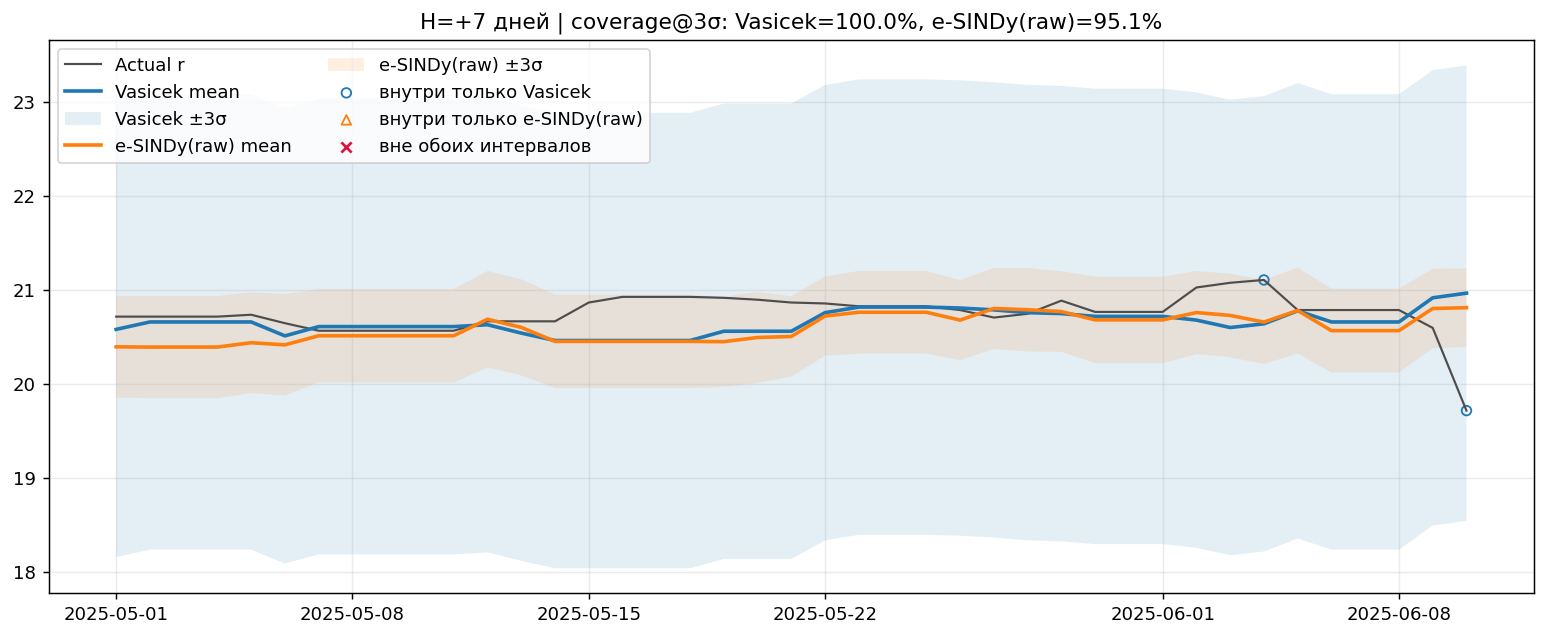

In [35]:
def _extract_pack_arrays(dates, r_series, pack, H,
                         start_date=np.datetime64('2025-05-01'),
                         end_date=np.datetime64('2025-06-10')):
    t_idx = np.asarray(pack[H]["t_index"])
    mean  = np.asarray(pack[H]["mean"], float)
    std   = np.asarray(pack[H]["std"],  float)

    valid = (t_idx + H) < len(r_series)
    if not np.any(valid):
        raise RuntimeError(f"Нет валидных точек для H={H}.")

    t_idx = t_idx[valid]; mean = mean[valid]; std = std[valid]
    fact  = r_series[t_idx + H]
    d_t   = dates[t_idx + H]

    # Обрезаем по датам с 1 мая по 1 июня включительно
    mask_date = (d_t >= start_date) & (d_t <= end_date)
    if not np.any(mask_date):
        raise RuntimeError("Нет точек в период с 2025-05-01 по 2025-06-01 для визуализации.")

    d_t, mean, std, fact = d_t[mask_date], mean[mask_date], std[mask_date], fact[mask_date]
    cov, inside = coverage_3sigma(fact, mean, std)
    return {"dates": d_t, "mean": mean, "std": std, "fact": fact, "inside": inside, "coverage": cov}

def get_e_sindy_raw7(dates, r_series):
    H_sel = 7
    pack = globals().get("sindyE_forecasts_test", None)
    if pack is None:
        raise RuntimeError("sindyE_forecasts_test не найден. Убедитесь, что вы вычислили e-SINDy(raw).")
    if H_sel not in pack:
        raise RuntimeError(f"В sindyE_forecasts_test отсутствует горизонт H={H_sel}.")
    return "e-SINDy(raw)", pack, H_sel

def plot_vas_vs_e_sindy_raw7(dates, r_series, vas_pack):
    label_e, pack_e, H = get_e_sindy_raw7(dates, r_series)

    vas = _extract_pack_arrays(dates, r_series, vas_pack, H)
    est = _extract_pack_arrays(dates, r_series, pack_e,  H)

    # общие даты
    common = np.intersect1d(vas["dates"], est["dates"])
    if common.size == 0:
        raise RuntimeError(f"Нет пересечения дат между Vasicek и {label_e} на H={H}.")

    def _align(arr):
        pos = np.searchsorted(arr["dates"], common)
        ok  = (pos>=0)&(pos< arr["dates"].size)&(arr["dates"][pos]==common)
        pos = pos[ok]
        return {k: arr[k][pos] for k in ["dates","mean","std","fact","inside"]}

    vas_a = _align(vas)
    est_a = _align(est)
    fact = vas_a["fact"]
    d_t  = vas_a["dates"]

    cov_v, _ = coverage_3sigma(fact, vas_a["mean"], vas_a["std"])
    cov_e, _ = coverage_3sigma(fact, est_a["mean"], est_a["std"])

    inside_v = vas_a["inside"]
    inside_e = est_a["inside"]
    only_v   =  inside_v & ~inside_e
    only_e   = ~inside_v &  inside_e
    neither  = ~inside_v & ~inside_e

    plt.figure(figsize=(12,5))
    plt.plot(d_t, fact, lw=1.2, color="0.3", label="Actual r")

    plt.plot(d_t, vas_a["mean"], lw=2.0, label="Vasicek mean")
    plt.fill_between(d_t,
                     vas_a["mean"]-3*vas_a["std"],
                     vas_a["mean"]+3*vas_a["std"],
                     alpha=0.12, label="Vasicek ±3σ")

    plt.plot(d_t, est_a["mean"], lw=2.0, label=f"{label_e} mean")
    plt.fill_between(d_t,
                     est_a["mean"]-3*est_a["std"],
                     est_a["mean"]+3*est_a["std"],
                     alpha=0.12, label=f"{label_e} ±3σ")

    plt.scatter(d_t[only_v],  fact[only_v],  s=28, marker="o", facecolors="none", edgecolors="C0",
                label="внутри только Vasicek")
    plt.scatter(d_t[only_e],  fact[only_e],  s=28, marker="^", facecolors="none", edgecolors="C1",
                label="внутри только e-SINDy(raw)")
    plt.scatter(d_t[neither], fact[neither], s=32, marker="x", color="crimson",
                label="вне обоих интервалов")

    plt.title(f"H=+{H} дней | coverage@3σ: Vasicek={cov_v*100:.1f}%, {label_e}={cov_e*100:.1f}%")
    plt.grid(alpha=0.25)
    plt.legend(loc="upper left", ncol=2)
    plt.tight_layout()
    plt.show()

# Пример вызова:
plot_vas_vs_e_sindy_raw7(dates, r_full, vas_forecasts_test)
